In [ ]:
# !pip install -U nltk #nltk 업그레이드 3.5이상으로

# Load

In [7]:
from tqdm.notebook import tqdm
import tensorflow as tf
from transformers import PreTrainedTokenizerFast
from transformers import TFGPT2LMHeadModel

tokenizer = PreTrainedTokenizerFast.from_pretrained('/content/drive/MyDrive/Colab Notebooks/2021-1_인공지능기술및응용1/kogpt2')
d_model = TFGPT2LMHeadModel.from_pretrained('taeminlee/kodialogpt2-base', from_pt=True)

In [2]:
import joblib
import random

path = '/content/drive/MyDrive/Colab Notebooks/2021-1_인공지능기술및응용1/'
scripts = joblib.load(path + 'scripts_150_400')

In [3]:
random.shuffle(scripts)

In [4]:
len(scripts)

58668

# pre - processing

In [8]:
# 반복문으로 합치기


def int_feature(value):
  return tf.train.Feature(int64_list = tf.train.Int64List(value=value))

filename = path + 'scripts.tfrecord'

with tf.io.TFRecordWriter(filename) as writer:
  for script in tqdm(scripts, total=len(scripts)):
    tokens = tokenizer.encode(script)
    tokens = [t for t in tokens if t < tokenizer.vocab_size]
    
    n = len(tokens)
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'tokens' : int_feature(tokens),
        'n' : int_feature([n]), #문장의 끝부분을 알아야 새로운 문장을 생성함
    }))

    s = example.SerializeToString()
    writer.write(s)

In [9]:
feature_description = {
    'tokens' : tf.io.FixedLenSequenceFeature(shape=(), dtype=tf.int64, allow_missing=True),
    'n' : tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
}

def parse_data(example):
  data = tf.io.parse_single_example(example, feature_description)
  data['tokens'] = tf.cast(data['tokens'], tf.int32)
  data['n'] = tf.cast(data['n'], tf.int32)
  return data

# finetuning

In [10]:
batch_size = 8
dataset = tf.data.TFRecordDataset(path + 'scripts.tfrecord')
dataset = dataset.map(parse_data).padded_batch(batch_size, padding_values=tokenizer.pad_token_id)

In [21]:
from tqdm.notebook import tqdm
import math

n_total = len(scripts)

opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)

for epoch in range(15):
  losses = 0
  ppls = 0
  for batch in tqdm(dataset, total=math.ceil(n_total//batch_size)):

    with tf.GradientTape() as tape:
      # result = model(batch['tokens'], labels=batch['tokens'])
      result = d_model(batch['tokens'], labels=batch['tokens']) ####
      loss = tf.reduce_mean(result['loss'])  
      losses += loss
      ppls += tf.exp(loss)
    # grads = tape.gradient(loss, model.trainable_variables)
    # opt.apply_gradients(zip(grads, model.trainable_variables))
    grads = tape.gradient(loss, d_model.trainable_variables)###
    opt.apply_gradients(zip(grads, d_model.trainable_variables)) ###
  print(f'epoch: {epoch}', end='\t')
  print('loss: ', losses.numpy() / (n_total//batch_size), end='\t')
  print('ppl: ', ppls.numpy() / (n_total//batch_size)) 

  # 매 에포크마다 모델 저장
  # model.save_pretrained(path+'my_model')
  d_model.save_pretrained(path+'my_d_model2') ####

###d_model
# 2.몇
# 2.2128303
# 2.1352947
# 2.0757377 / 8.134315


############## training loss
# 1 - 2.2039573 // 9.547796


epoch: 0	loss:  2.0149423517830356	ppl:  7.723076546093004



epoch: 1	loss:  3.948048952509205	ppl:  14.817677792172372



epoch: 2	loss:  5.817253767216692	ppl:  21.456779285422066



epoch: 3	loss:  7.628620192963316	ppl:  27.708696986226645



epoch: 4	loss:  9.38357744954316	ppl:  33.60441880880949



epoch: 5	loss:  11.080783146393017	ppl:  39.157187542615574



epoch: 6	loss:  12.716953753579709	ppl:  44.37016739397245



epoch: 7	loss:  14.287859675439792	ppl:  49.243667325787534



epoch: 8	loss:  15.788548982340107	ppl:  53.77765750715942



epoch: 9	loss:  17.21406015614346	ppl:  57.97656995772535



epoch: 10	loss:  18.56025629005864	ppl:  61.850018750852314


KeyboardInterrupt: ignored

In [42]:
### 3e-5 12에폭후 학습률 높여서 3e-4
n_total = len(scripts)

opt = tf.keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-08) ##학습률 높임

for epoch in range(1):
  losses = 0
  ppls = 0
  for batch in tqdm(dataset, total=math.ceil(n_total//batch_size)):

    with tf.GradientTape() as tape:
      # result = model(batch['tokens'], labels=batch['tokens'])
      result = d_model(batch['tokens'], labels=batch['tokens']) ####
      loss = tf.reduce_mean(result['loss'])  
      losses += loss
      ppls += tf.exp(loss)
    # grads = tape.gradient(loss, model.trainable_variables)
    # opt.apply_gradients(zip(grads, model.trainable_variables))
    grads = tape.gradient(loss, d_model.trainable_variables)###
    opt.apply_gradients(zip(grads, d_model.trainable_variables)) ###
  print(f'epoch: {epoch}', end='\t')
  print('loss: ', losses.numpy() / (n_total//batch_size), end='\t')
  print('ppl: ', ppls.numpy() / (n_total//batch_size)) 
  d_model.save_pretrained(path+'my_d_model2')

# training loss
#13- 1.78 // 
#14 -  1.55 // 4.8
# 15- 1.36 // 3.92
# 16 - 1.19 // 3.3
# 17 - 1.04 // 2.86
# 18 - 0.9293 // 2.544
# 19 - 0.8280 // 2.29
# 20 - 0.741 // 2.106
# 21 - 0.6677 // 1.956
# 22 - 0.60445 // 1.83557
# 23 - 0.54902 // 1.73600
# 24 - 0.50129 // 1.65461
# 25 - 


epoch: 0	loss:  0.501297178103266	ppl:  1.6546184894057685


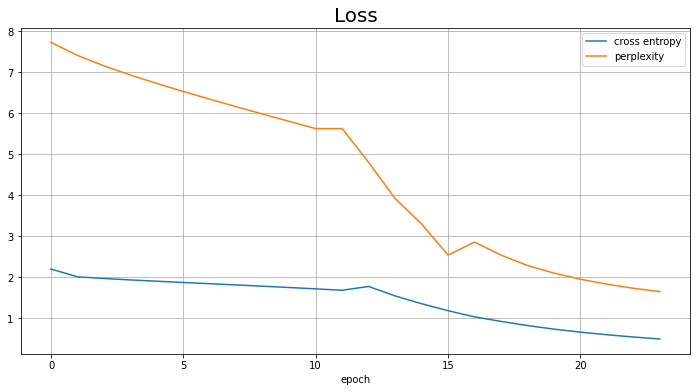

In [53]:
import matplotlib.pyplot as plt

# loss를 저장하는 변수를 만들어두지 않아서
# 직접 하드코딩...
losses_ = [2.2039573, 2.01494, 3.94804/2, 5.81725/3, 7.628620/4, 9.38357/5, 11.0807/6, 12.716953/7, 14.2878/8, 15.7885/9, 17.2140/10, 18.560256/11, 
           1.78, 1.55, 1.36, 1.19, 1.04, 0.9293, 0.8282, 0.741, 0.6677, 0.60445, 0.54902, 0.50129]
ppls_ = [7.72, 14.81/2, 21.45/3, 27.7086/4, 33.60441/5, 39.15718/6, 44.370167/7, 49.243667/8, 53.77765/9, 57.97656/10, 61.8500187/11, 
        61.8500187/11, 4.8, 3.92, 3.3, 2.544, 2.86, 2.544, 2.29, 2.106, 1.956, 1.83557, 1.73600, 1.65461]
plt.figure(figsize=(12, 6))
plt.plot(losses_, label='cross entropy')
plt.plot(ppls_, label='perplexity')
plt.legend()
plt.grid()
plt.title('Loss', size=20)
plt.xlabel('epoch')
plt.show()

# 가중치 동결 모델(미사용)

In [ ]:
model2 = TFGPT2Model.from_pretrained('taeminlee/kogpt2', from_pt=True, trainable=False)

def fc_model():
  input_ = tf.keras.Input(shape = (None, 768))
  layer = tf.keras.layers.Dense(768)(input_)
  layer = tf.keras.layers.Activation('swish')(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.Dense(50000)(layer)
  output_ = tf.keras.layers.Softmax()(layer)

  fc_model = tf.keras.Model(input_, output_)
  fc_model.compile(optimizer = 'adam', loss='categorical_crossentropy')

  return fc_model


fc_model = fc_model()

from tqdm.notebook import tqdm
import math

n_total = len(scripts)
n_correct = 0

opt = tf.keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-08)
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)


for epoch in range(1):
  for batch in tqdm(dataset, total=math.ceil(n_total//batch_size)):

    with tf.GradientTape() as tape:
      gpt_result = model2(batch['tokens'])
      fc_result = fc_model(gpt_result[0])
      probs = tf.one_hot(batch['tokens'], 50000)

      loss = loss_func(probs, fc_result)

    grads = tape.gradient(loss, fc_model.trainable_variables)
    opt.apply_gradients(zip(grads, fc_model.trainable_variables))
  # 매 에포크마다 모델 저장
  fc_model.save_pretrained(path+'my_fc_model')

# 평가

In [ ]:
# 모델 불러오기
d_model = TFGPT2LMHeadModel.from_pretrained(path+'my_d_model2')

In [ ]:
def generate_script(input_model, text, temperature, do_sample=False):

  input_ids = tokenizer.encode(text, return_tensors='tf')
  output = input_model.generate(input_ids, 
                        max_length=200,
                        min_length= 20,
                        num_beams=5, # 최대 5개의 후보 유지
                        early_stopping=True, 
                        eos_token_id = tokenizer.eos_token_id, #문자의 끝을 나타내는 토큰
                        pad_token_id = tokenizer.pad_token_id, # 문장의 빈칸?을 채우는 문자
                        do_sample=do_sample, 
                        no_repeat_ngram_size= 2,
                        temperature=temperature,                    
                        )
  
  answer = tokenizer.decode(output[0])
  answer = answer.replace('>>', '\n')
  
  return answer

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction, modified_precision, sentence_bleu

def eval_bleu(script):
  origin = script
  print('origin: \n',origin, end='\n\n')

  border = origin.index('>>') + origin[origin.index('>>')+1:].index('>>')
  sent = origin[:border]+'\n>>'
  print('sent: \n', sent, end='\n\n')

  gen = generate_script(d_model, sent, 0.7, True)
  print('gen: \n', gen, end='\n\n')

  ref = [origin[border:].replace('>>', '').split()]
  sentence = gen[border:].split()

  bleu_score = sentence_bleu(ref, sentence, smoothing_function=SmoothingFunction().method2)

  return bleu_score

In [62]:
print(eval_bleu(scripts[25498]))

origin: 
 title: 이산 19회 #74
speakers: 화완, 홍인한, 중신1, 정순, 다들, 효의
>>화완:왜요? 세손이 보위를 이를 것 같으니 마음이 흔들리십니까?
>>홍인한:(당혹, 발끈) 마마, 어찌 그런 망극한 말씀을 하십니까?
>>중신1:물론입니다. 신료들은 내일 있을 차대는 물론, 세손이 주관하는 대전회의에는 누구도 들지 않을 것입니다.
>>정순:(E) 그건 좋은 방법이 아닙니다.
>>다들:....!!....
>>효의:어마마마..

sent: 
 title: 이산 19회 #74
speakers: 화완, 홍인한, 중신1, 정순, 다들, 효의
>>화완:왜요? 세손이 보위를 이를 것 같으니 마음이 흔들리십니까?
>>

gen: 
 title: 이산 19회 #74speakers: 화완, 홍인한, 중신1, 정순, 다들, 효의
화완:왜요? 세손이 보위를 이를 것 같으니 마음이 흔들리십니까?
홍인한:세손의 궁지에 몰리기 때문이요. 포도청의 궁인들은 어찌할 것이오? (하는데)
중신1:예? 아니, 세손저할 저희가 어찌 되겠수?!! (하고) 아니지요, 전하. 신 그렇지 않사옵니까? 허면 지금 저희들은.... 한가하게 술이나 마실 수 있는 자리란 겁니까? 여봐요 홍국영이를 찾으시는거예요. 지금 당장 저들과 함께 주상전하께 역당들도 잡아내고 신 권세를 누리게 해달라구요. 허구헌 날들 뭘로 쏘다니느라 온 집안이 요 모양 요 꼴이 다됐구만 쥐새끼처럼 지 할미를 못 보시오. 으지?

0.01632803354351341


In [65]:
text = 'title: 인공지능기술과응용 1회 #22 speakers: 갑, 을, 병, 정\n>>갑: 중간고사 프로젝트가 끝나간다...\n>>'

print(generate_script(d_model, text, 0.2, True))
print()
print(generate_script(d_model, text, 0.5, True))

title: 인공지능기술과응용 1회 #22 speakers: 갑, 을, 병, 정
갑: 중간고사 프로젝트가 끝나간다...
을, 다같이 웃으며) 하이구, 해냈어. (병에게 손짓하고/ 병에게 살갑게) 해 볼까나?
(병:우리 아버지도 아니고, 세 사람 다 우리 걱정이었으니까 그것도 문제지만, 너라도 먼저 나와 있어봐. 저녁은 정 없이 먹고, 아침은 죽으로 때우자. 정성은 정만큼만 먹여놔야 한다니까. 응? (가려면)
정:기말고사 끝나면 영화 보러 갈까 하는데, 우리 준희가 안 와서 걱정이에요. 시간되면 준희랑 미영이랑 셋이 데이트 어떠시려나 했는데, 역시 넌 쪽집 이름은 정해이 안됐구. 락을 끊고 둘이 쌍으로 줄서서 기다리기만 하구... (한숨) 이놈의 기집애, 지새끼

title: 인공지능기술과응용 1회 #22 speakers: 갑, 을, 병, 정
갑: 중간고사 프로젝트가 끝나간다...
을, 다같이 술렁이는데)
병:우리만 빼놓고 잔거야? (기분 나쁘지만, 태연하게 술잔 치며) 임마, 니가 어째서 이럼 나보다 더 바빴냐? 너나 나나 이뻐지는 게 당연하지!! 내 자식 아니었으면 나 같은 놈 건배사리는 꿈도 꾸지 못했어?! (지 침대 끌어안고 엎어져 벌떡 일어난다) 이 놈의 기집애, 코 빠트리고 눕혀놓고 끙끙대고 있어! (갑의 다리 잡아당겨 앉히며) 고새를 못 참고 밥도 안 먹고 고생하나보군 그래두 니 눈엔 이놈의 하이에미가 순순히 응한 거 같애. 응? 이러다 애물딱지 생색은 낼 참


In [67]:
text = 'title: 궁 16회 #46\n>>박 상궁: 마마, 박 상궁이옵니다.\n>>황후:'
print(generate_script(d_model, text, 0.2, True))
print()
print(generate_script(d_model, text, 0.5, True))
print()
print(generate_script(d_model, text, 0.7, True))

title: 궁 16회 #46
박 상궁: 마마, 박 상궁이옵니다.
황후:어마마께서 저희 황후를 보내주시다니.. 저는 참으로 서운하옵니다.. 이토록 오래 버티고 기다리시던, 아니되옵니다, 하오니 태후를 친드신 최 상질의 일거 일투가 신문까지... 참혹 하옵니까.. 어찌 되었건, 저로선 누추한 곳까지 가신 것이 그 자신만스러우옵니다... 하오나... 면목이 없습니다..<pad><pad>떡하니.<pad>까~ 왕에블~ (정말 괜찮다)<pad>어떡 하니. (한숨) 흐흐흑~ 황태전~~<pad>어야 하는데.... 스스끼츠 황태후는 잘 하두 질려서 못따라온 건데... 히히... (신 신 나고)
황제:황후가 여기 모이기 싫어서 황후 자리를 내주지 않겠다.. 흥신하는 구만. 그게 지 무덤이다

title: 궁 16회 #46
박 상궁: 마마, 박 상궁이옵니다.
황후:이걸 어찌 혼자 즐기셨겠사옵니까. 폐하께서 궁을 나가셨는데도, 그래도 황제께서 웃으며 뛰쳐다니고 계실 줄은 모르겠습니다. (눈빛 살벌하게) 누가 황제 폐하를 맞추게 만들다니, 이게 무슨 소린가~ 그래, 어서 피하거라! 누가 이기나 오랑캐가 승산이 있을 때까지만이라도 요양을 해야지, 심심하면 웬쫄이라도 가서 추위를 이기자면, (변명처럼) 헌데, 황후께서도 이젠 안색이 어두우십니다. 아무래도, 태후를커플로 만들어 줘야 할 거 아니겠습니까? 황상께서는 지금 너무 완강합니다. 무슨 말씀을 하시시는지 제가 더 잘 아실 것이구요. 말씀은 좀 하시지요. 아드님은 좀 괜찮으십니까. 뭐 좀 볼 일 있으십니까? (신 신 보며

title: 궁 16회 #46
박 상궁: 마마, 박 상궁이옵니다.
황후:어째서 궁까지 왔는지 모르겠구나.. 황후전에선 태후를 빼면 혜정전마마께서 혼자 일을 하신거늘.. 대체 어찌 된 일인 게야..? (기막혀서 웃는데)
서경1:황실 일에 아는 것도 많구.. 이해 좀 됩니다만. 이 기회에 다들 황태자비로 모시고 사는 게 어떻겠는지. 다들 노여워 좀 하십쇼. 알았으니 어서 나가 계셔도 좋으련만... (하다 입 딱 벌어